In [35]:
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from community import community_louvain
import time
np.random.seed(0)
random.seed(0)

In [36]:
def Clauset_Network(num_vertices, num_communities, cross_community_edges):
    '''
    Takes as parameters the number of vertices in the network, number of communtites to have in the network and number of cross_community edges
    Returns the list of vertices and edges, and a dictionary of communities.
    '''

    '''
    Vertices are labelled from 0 to num_vertices-1.
    Communities are labelled from 0 to num_communities.
    '''

    # store vertices and edges in form of lists
    Vertices = [i for i in range(num_vertices)]
    Edges = set()
    Degree = [0 for i in range(num_vertices)]

    # communities to be stored in a dictionary with community label as key and list of edges as value
    communities = {}
    for i in range(num_communities):
        communities[i] = []

    # generating clauset network
    for i in communities:
        for j in Vertices:
            if random.random() < num_communities / num_vertices:
                communities[i].append(j)

    for i in communities:
        for j in communities[i]:
            for _ in range(num_communities + 1):
                x = j
                while (x == j):
                    x = random.choice(communities[i])
                x, j = min(x, j), max(x, j)
                Edges.add((x, j))
                Degree[x] += 1
                Degree[j] += 1

    for i in range(cross_community_edges):
        c1 = c2 = -1
        while(c1 == c2):
            c1 = random.randint(0, num_communities - 1)
            c2 = random.randint(0, num_communities-1)
        while(True):
            x = random.choice(communities[c1])
            y = random.choice(communities[c2])
            x, y = min(x, y), max(x, y)
            if(x != y and Degree[x] >= 2 * num_communities and Degree[y] >= 2 * num_communities and ((x, y) not in Edges)):
                break
        Edges.add((x, y))

    Edges = list(Edges)
    
    P = nx.Graph()
    P.add_nodes_from(Vertices)
    P.add_edges_from(Edges)

    return P

In [37]:
def add_feature_vector(G, d):
    '''
    Takes as input: a networkx graph and a list specifying the type of distribution as key and repuired parameters as values
    Gives output: a networkx graph with feature vector for each node labelled as feature and can be accessed using G.nodes[i]['feature']
    '''

    '''
    Distributions: 'normal', 'power', 'uniform'
    example: [('uniform', (lower, upper)), ('uniform', (lower, upper)), ('power', (a, lower, upper)), ('normal', (mean, deviation)), ('uniform', (lower, upper))] is a valid value for argument d
    '''

    '''
    Uniform and Power distribution will make characterstic value lie in range (lower, upper)
    but values for normal distribution characteristic depends on mean and deviation input
    '''

    '''
    This function adds feature vector to the graph
    Feature vector is a numpy array
    '''

    num_vertices = G.number_of_nodes()
    samples = []
    for i in d:
        if i[0] == 'uniform':
            lower = i[1][0]
            upper = i[1][1]
            sample = [np.random.uniform(lower, upper)
                      for i in range(num_vertices)]
        elif i[0] == 'power':
            a = i[1][0]
            lower = i[1][1]
            upper = i[1][2]
            sample = np.random.power(a, num_vertices)
            for j in range(num_vertices):
                sample[j] = sample[j] * (upper - lower) + lower
        elif i[0] == 'normal':
            mean = i[1][0]
            deviation = i[1][1]
            sample = np.random.normal(mean, deviation, num_vertices)
        else:
            raise Exception(i[0] + "is not a valid distribution type")

        samples.append(list(sample))

    x = 0
    for i in G.nodes:
        feature = []
        for it in range(5):
            feature.append(samples[it][x])
        x += 1

        feature = np.array(feature)
        G.nodes[i]['feature'] = feature

    return G

In [38]:
def add_vulnerability_of_node(G, distribution, lower, upper, a = 0):
    '''
    Takes as input: a networkx graph, the distribution type of vulnerability - alpha's distribution, lower limit, upper limit, a(required only if distribution = 'power')
    Gives output: a networkx graph with vulnerability for each node labelled as vulnerability and can be accessed using G.nodes[i]['vulnerability']
    '''

    '''
    Distributions: 'power', 'uniform'
    '''

    '''
    Uniform and Power distribution will make characterstic value lie in range (lower, upper)
    Since, the value of vulnerability must be between 0(not at all vulnerable) and 1(fully vulnerable) the lower and upper must be in accordance with this
    '''

    '''
    This function assigns vulnerability value to each node in the graph
    Vulnerability is just a floating point value in the range of 0 and 1
    '''

    if lower < 0:
        raise Exception(lower + "is not a valid value for lower limit")
    if upper > 1:
        raise Exception(upper + "is not a valid value for upper limit")
    if lower > upper:
        raise Exception("Lower limit cannot be greater than the upper limit")

    num_vertices = G.number_of_nodes()
    samples = []
    if distribution == 'uniform':
        sample = [np.random.uniform(lower, upper)
                    for i in range(num_vertices)]
    elif distribution == 'power':
        sample = np.random.power(a, num_vertices)
        for j in range(num_vertices):
            sample[j] = sample[j] * (upper - lower) + lower
    else:
        raise Exception(distribution + "is not a valid distribution type")
    
    samples.append(list(sample))

    x = 0
    for i in G.nodes:
        G.nodes[i]['vulnerability'] = sample[x]
        x += 1

    return G

In [39]:
def add_age_to_edges(G):
    '''
    Takes as input: a networkx graph
    Gives output: a networkx graph with each edge having a label of age (time for which the edge has existed)
    '''

    '''
    Whenever a new edge is added, its time is initialized to 1 and incremented with each time step
    '''

    for i in G.edges:
        G.edges[i]['age'] = 1

    return G

In [40]:
def Simulate(G, num_time_steps, threshold, edge_strength = 1):
    '''
    Takes as parameters the networkx graph, number of time steps for which the simulation is to be run and threshold at which two nodes are to be connected
    Returns the updated graph
    edge_strength is not a parameter to be taken care of. 0 value refers to the situation in which older edges are more stronger and 1 value - the opposite
    '''

    for _ in range(num_time_steps):
        G = simulate_one_time_step(G, threshold, edge_strength)

    return G

In [41]:
def simulate_one_time_step(G, threshold, edge_strength):
    '''
    This function just acts as a helper function for the function Simulate
    '''

    # create a copy of graph G which is to be updated
    H = G.copy()

    # iterate over all the nodes of the Graph and update the feature vector for them on the basis of their neighbours
    for i in G.nodes:
        initial_array = G.nodes[i]['feature']
        neighbours = list(G.neighbors(i))

        if len(neighbours) == 0:
            break

        # target array is the weighted mean of feature vectors weighted over their age
        target_array = np.array([0.0 for i in range(5)])

        total_weight = 0

        if edge_strength == 0:
            for j in neighbours:
                target_array += G.nodes[j]['feature'] * G.edges[(i, j)]['age']
                total_weight += G.edges[(i, j)]['age']
                # incrementing age of each edge
                G.edges[(i, j)]['age'] += 1
        else:
            for j in neighbours:
                target_array += G.nodes[j]['feature'] / G.edges[(i, j)]['age']
                total_weight += 1 / G.edges[(i, j)]['age']
                # incrementing age of each edge
                G.edges[(i, j)]['age'] += 1
        
        target_array /= total_weight

        alpha = G.nodes[i]['vulnerability']
        
        # performing update on the feature vectors of the graph
        H.nodes[i]['feature'] = (1 - alpha) * initial_array + alpha * target_array
    
    # now iterate over all the nodes and establish links between two nodes if their feature vectors agree over certain range and they are separated by atmost one node
    # also break edges which have become weaker than the threshold

    for i in H.nodes:
        prospective = set()
        neighbours = list(H.neighbors(i))

        ''' 
        the loop below contains two blocks, depending on their relative positioning (which one first), the code changes as follows
        (1) the code removes the edges which are now below the threshold value and takes the neighbours of only remaining edges as prospectives
        (2) the code first takes all the nodes separated by one node as prospective nodes and then deletes all the immediate nodes that are below threshold now
        Currently the order is such that (2) is being followed
        '''
        for j in neighbours:
            # block 1 starts
            j_neighbours = list(H.neighbors(j)) 
            for k in j_neighbours:
                if H.has_edge(i, k) == False:
                    prospective.add(k)
            # block 1 ends

            # block 2 starts
            x1, x2 = H.nodes[i]['feature'], H.nodes[j]['feature']
            commonality = np.sum (x1 * x2) / ( np.linalg.norm(x1) * np.linalg.norm(x2) )

            if commonality < threshold or random.random() < 0.1:
                H.remove_edge(i, j)
            # block 2 ends
            
        
        prospective = list(prospective)
        
        for j in prospective:
            x1, x2 = H.nodes[i]['feature'], H.nodes[j]['feature']
            commonality = np.sum (x1 * x2) / ( np.linalg.norm(x1) * np.linalg.norm(x2) )

            if commonality >= threshold and random.random() < 0.9:
                H.add_edge(i, j)
                H.edges[(i, j)]['age'] = 1

    return H

In [42]:
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

In [43]:
def get_clusters(G):
    '''
    The only argument is networkx graph.
    The output is list of clusters(which in turn is a list itself)
    eg: [[1, 2, 3],[4, 5, 6], [7, 8, 9], [10, 11, 12]] indicates presence of 4 clusters having 3 nodes each 
    '''
    
    community_dict = community_louvain.best_partition(G)
    
    # Block starts: to obtain the number of communities
    mx = float('-inf')
    for i in community_dict:
        mx = max(mx, community_dict[i])
    mx += 1
    # Block ends

    clusters = [[] for i in range(mx)]

    for i in community_dict:
        clusters[community_dict[i]].append(i)
    
    return clusters

# Final Graph

In [44]:
G = Simulate(G, 1000, 0.95)
partition = community_louvain.best_partition(G)
nx.draw(G, pos, node_color=list(partition.values()), with_labels = 1);
plt.show()

KeyError: 'feature'

In [45]:
get_clusters(G)

[[0],
 [1],
 [2, 9, 28, 32, 52, 56, 135, 137, 143, 149, 152, 224, 272],
 [3],
 [4],
 [5,
  30,
  65,
  97,
  100,
  104,
  116,
  121,
  127,
  131,
  134,
  142,
  162,
  251,
  266,
  269,
  281,
  282,
  283],
 [6],
 [7],
 [8],
 [10],
 [11],
 [12, 47, 71, 88, 89, 95, 103, 202, 203, 221, 228, 234, 244, 293],
 [13],
 [14],
 [15],
 [16],
 [17],
 [18],
 [19],
 [20],
 [21],
 [22],
 [23],
 [24, 62, 66, 94, 138, 196, 257],
 [25],
 [26],
 [27],
 [29],
 [31],
 [33, 36, 74, 99, 101, 114, 139, 184, 188, 230, 279, 288, 290],
 [34],
 [35],
 [37],
 [38],
 [39],
 [40],
 [41],
 [42],
 [43],
 [44],
 [45,
  59,
  60,
  82,
  87,
  90,
  112,
  148,
  174,
  175,
  177,
  185,
  208,
  211,
  270,
  280,
  284,
  287,
  298],
 [46],
 [48],
 [49],
 [50],
 [51],
 [53],
 [54],
 [55],
 [57],
 [58],
 [61],
 [63],
 [64],
 [67],
 [68],
 [69],
 [70],
 [72],
 [73],
 [75],
 [76],
 [77],
 [78],
 [79],
 [80],
 [81],
 [83],
 [84],
 [85],
 [86],
 [91],
 [92],
 [93],
 [96],
 [98],
 [102],
 [105],
 [106],
 [107],
 [1

In [107]:
G = Clauset_Network(300, 10, 5)

# Initial Graph

In [108]:
pos = nx.circular_layout(G)

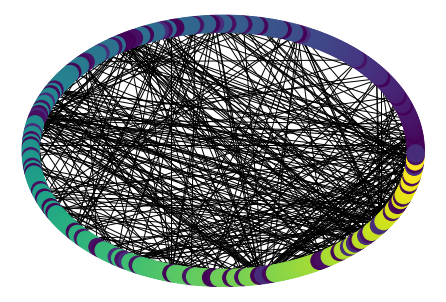

In [109]:
partition = community_louvain.best_partition(G)
nx.draw(G, pos, node_color=list(partition.values()), with_labels = 0);

In [111]:
G.number_of_edges()

385

# first 10 simulations

[0] [1, 7, 74, 100, 118, 131, 134, 138, 200, 230, 234, 271, 298] [2] [3] [4] [5] [6, 10, 90, 99, 136, 146, 186, 251, 276, 279, 295] [8] [9] [11] [12, 38, 113, 152, 191, 217] [13] [14] [15] [16] [17] [18] [19] [20] [21, 56, 77, 102, 114, 137, 143, 174, 197, 235, 236, 299] [22] [23] [24] [25] [26] [27] [28] [29, 60, 98, 104, 126, 261] [30] [31, 55, 70, 128, 172, 223, 237, 259, 265, 266, 280] [32] [33] [34] [35] [36] [37] [39] [40] [41] [42] [43] [44] [45] [46] [47] [48] [49] [50] [51] [52] [53] [54] [57] [58] [59] [61] [62] [63] [64] [65] [66, 290] [67] [68] [69] [71] [72] [73] [75] [76] [78] [79] [80] [81] [82] [83] [84] [85] [86] [87] [88] [89] [91, 95] [92] [93] [94] [96] [97] [101] [103] [105] [106] [107] [108] [109] [110] [111] [112] [115] [116] [117] [119] [120] [121] [122] [123] [124] [125] [127] [129] [130] [132] [133] [135] [139, 156, 252] [140] [141] [142] [144] [145] [147] [148] [149] [150] [151] [153] [154] [155] [157] [158] [159] [160] [161] [162] [163] [164] [165] [166] [16

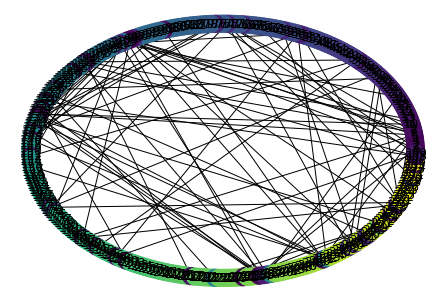

[0] [1, 7, 31, 55, 74, 100, 118, 131, 134, 138, 172, 200, 230, 234, 271, 280] [2] [3] [4] [5] [6, 10, 90, 99, 136, 146, 186, 251, 276, 279, 295] [8] [9] [11] [12, 38, 113, 152, 191] [13] [14] [15] [16] [17] [18] [19] [20] [21, 56, 77, 102, 114, 137, 139, 143, 156, 174, 235, 236, 252, 298] [22] [23] [24] [25] [26] [27] [28] [29, 104, 126] [30] [32] [33] [34] [35] [36] [37] [39] [40] [41] [42] [43] [44] [45] [46] [47] [48] [49] [50] [51] [52] [53] [54] [57] [58] [59] [60, 98, 261] [61] [62] [63] [64] [65] [66] [67] [68] [69] [70] [71] [72] [73] [75] [76] [78] [79] [80] [81] [82] [83] [84] [85] [86] [87] [88] [89] [91, 95] [92] [93] [94] [96] [97] [101] [103] [105] [106] [107] [108] [109] [110] [111] [112] [115] [116] [117] [119] [120] [121] [122] [123] [124] [125] [127] [128, 259, 265, 266] [129] [130] [132] [133] [135] [140] [141] [142] [144] [145] [147] [148] [149] [150] [151] [153] [154] [155] [157] [158] [159] [160] [161] [162] [163] [164] [165] [166] [167] [168] [169] [170] [171] [1

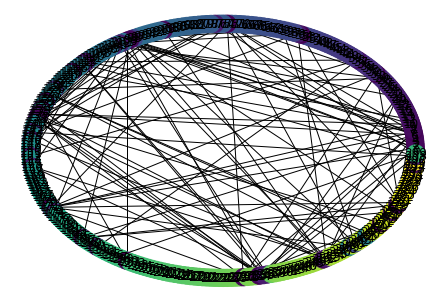

[0] [1, 7, 31, 55, 74, 100, 134, 138, 172, 174, 200, 230, 234, 271, 280] [2] [3] [4] [5] [6, 10, 90, 99, 136, 146, 186, 251, 276, 279, 295] [8] [9] [11] [12, 38, 113, 152, 191] [13] [14] [15] [16] [17] [18] [19] [20] [21, 56, 77, 102, 114, 137, 139, 143, 156, 235, 236, 252, 298] [22] [23] [24] [25] [26] [27] [28] [29, 104, 126] [30] [32] [33] [34] [35] [36] [37] [39] [40] [41] [42] [43] [44] [45] [46] [47] [48] [49] [50] [51] [52] [53] [54] [57] [58] [59] [60, 98, 261] [61] [62] [63] [64] [65] [66] [67] [68] [69] [70] [71] [72] [73] [75] [76] [78] [79] [80] [81] [82] [83] [84] [85] [86] [87] [88] [89] [91, 95] [92] [93] [94] [96] [97] [101] [103] [105] [106] [107] [108] [109] [110] [111] [112] [115] [116] [117] [118, 131] [119] [120] [121] [122] [123] [124] [125] [127] [128, 259, 265, 266] [129] [130] [132] [133] [135] [140] [141] [142] [144] [145] [147] [148] [149] [150] [151] [153] [154] [155] [157] [158] [159] [160] [161] [162] [163] [164] [165] [166] [167] [168] [169] [170] [171] [

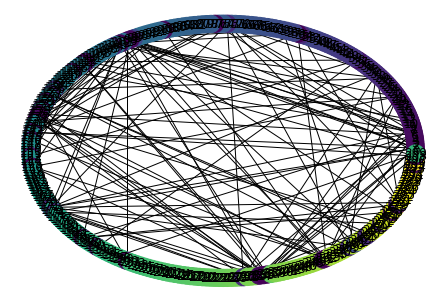

[0] [1, 7, 31, 55, 74, 100, 118, 131, 134, 138, 172, 174, 200, 230, 234, 271, 280] [2] [3] [4] [5] [6, 10, 90, 99, 136, 146, 186, 251, 276, 279, 295] [8] [9] [11] [12, 38, 113, 152, 191] [13] [14] [15] [16] [17] [18] [19] [20] [21, 56, 77, 102, 114, 137, 139, 143, 156, 235, 236, 252, 298] [22] [23] [24] [25] [26] [27] [28] [29, 104, 126] [30] [32] [33] [34] [35] [36] [37] [39] [40] [41] [42] [43] [44] [45] [46] [47] [48] [49] [50] [51] [52] [53] [54] [57] [58] [59] [60, 98, 261] [61] [62] [63] [64] [65] [66] [67] [68] [69] [70] [71] [72] [73] [75] [76] [78] [79] [80] [81] [82] [83] [84] [85] [86] [87] [88] [89] [91, 95] [92] [93] [94] [96] [97] [101] [103] [105] [106] [107] [108] [109] [110] [111] [112] [115] [116] [117] [119] [120] [121] [122] [123] [124] [125] [127] [128, 259, 265, 266] [129] [130] [132] [133] [135] [140] [141] [142] [144] [145] [147] [148] [149] [150] [151] [153] [154] [155] [157] [158] [159] [160] [161] [162] [163] [164] [165] [166] [167] [168] [169] [170] [171] [1

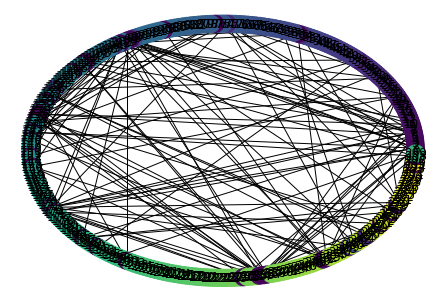

[0] [1, 7, 74, 100, 134, 138, 172, 174, 200, 230, 234, 271] [2] [3] [4] [5] [6, 10, 90, 99, 136, 146, 186, 251, 276, 279, 295] [8] [9] [11] [12, 38, 113, 152, 191] [13] [14] [15] [16] [17] [18] [19] [20] [21, 56, 77, 102, 114, 137, 139, 143, 156, 235, 236, 252, 298] [22] [23] [24] [25] [26] [27] [28] [29, 104, 126] [30] [31, 128, 259, 265, 266, 280] [32] [33] [34] [35] [36] [37] [39] [40] [41] [42] [43] [44] [45] [46] [47] [48] [49] [50] [51] [52] [53] [54] [55] [57] [58] [59] [60, 98, 261] [61] [62] [63] [64] [65] [66] [67] [68] [69] [70] [71] [72] [73] [75] [76] [78] [79] [80] [81] [82] [83] [84] [85] [86] [87] [88] [89] [91, 95] [92] [93] [94] [96] [97] [101] [103] [105] [106] [107] [108] [109] [110] [111] [112] [115] [116] [117] [118, 131] [119] [120] [121] [122] [123] [124] [125] [127] [129] [130] [132] [133] [135] [140] [141] [142] [144] [145] [147] [148] [149] [150] [151] [153] [154] [155] [157] [158] [159] [160] [161] [162] [163] [164] [165] [166] [167] [168] [169] [170] [171] 

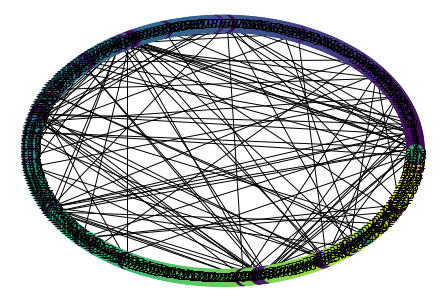

[0] [1, 7, 10, 31, 74, 172, 174, 230, 236, 271, 280, 298] [2] [3] [4] [5] [6, 90, 99, 136, 146, 186, 251, 276, 279, 295] [8] [9] [11] [12, 38, 113, 152, 191] [13] [14] [15] [16] [17] [18] [19] [20] [21, 56, 77, 102, 114, 137, 139, 143, 156, 235, 252] [22] [23] [24] [25] [26] [27] [28] [29, 104, 126] [30] [32] [33] [34] [35] [36] [37] [39] [40] [41] [42] [43] [44] [45] [46] [47] [48] [49] [50] [51] [52] [53] [54] [55] [57] [58] [59] [60, 98, 261] [61] [62] [63] [64] [65] [66] [67] [68] [69] [70] [71] [72] [73] [75] [76] [78] [79] [80] [81] [82] [83] [84] [85] [86] [87] [88] [89] [91, 95] [92] [93] [94] [96] [97] [100, 118, 131, 134, 138, 200, 234] [101] [103] [105] [106] [107] [108] [109] [110] [111] [112] [115] [116] [117] [119] [120] [121] [122] [123] [124] [125] [127] [128, 259, 265, 266] [129] [130] [132] [133] [135] [140] [141] [142] [144] [145] [147] [148] [149] [150] [151] [153] [154] [155] [157] [158] [159] [160] [161] [162] [163] [164] [165] [166] [167] [168] [169] [170] [171] 

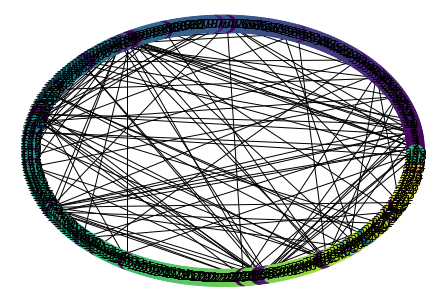

[0] [1, 21, 56, 77, 102, 114, 137, 139, 143, 156, 235, 236, 252, 298] [2] [3] [4] [5] [6, 10, 90, 99, 136, 146, 186, 251, 276, 279, 295] [7, 100, 118, 131, 134, 138, 174, 200, 230, 234, 271] [8] [9] [11] [12, 38, 113, 152] [13] [14] [15] [16] [17] [18] [19] [20] [22] [23] [24] [25] [26] [27] [28] [29, 104, 126] [30] [31, 74, 128, 172, 259, 265, 266, 280] [32] [33] [34] [35] [36] [37] [39] [40] [41] [42] [43] [44] [45] [46] [47] [48] [49] [50] [51] [52] [53] [54] [55] [57] [58] [59] [60, 98, 261] [61] [62] [63] [64] [65] [66] [67] [68] [69] [70] [71] [72] [73] [75] [76] [78] [79] [80] [81] [82] [83] [84] [85] [86] [87] [88] [89] [91, 95] [92] [93] [94] [96] [97] [101] [103] [105] [106] [107] [108] [109] [110] [111] [112] [115] [116] [117] [119] [120] [121] [122] [123] [124] [125] [127] [129] [130] [132] [133] [135] [140] [141] [142] [144] [145] [147] [148] [149] [150] [151] [153] [154] [155] [157] [158] [159] [160] [161] [162] [163] [164] [165] [166] [167] [168] [169] [170] [171] [173] 

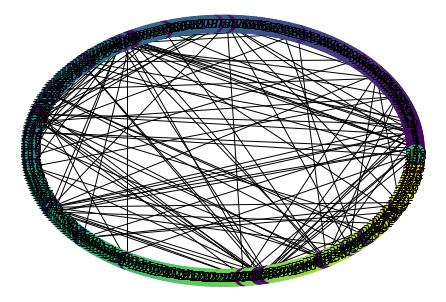

[0] [1, 10, 236, 298] [2] [3] [4] [5] [6, 90, 99, 136, 146, 186, 251, 276, 279, 295] [7, 100, 118, 131, 134, 138, 174, 200, 230, 234, 271] [8] [9] [11] [12, 38, 113, 152] [13] [14] [15] [16] [17] [18] [19] [20] [21, 56, 77, 102, 114, 137, 139, 143, 156, 235, 252] [22] [23] [24] [25] [26] [27] [28] [29, 104, 126] [30] [31, 74, 128, 172, 259, 265, 266, 280] [32] [33] [34] [35] [36] [37] [39] [40] [41] [42] [43] [44] [45] [46] [47] [48] [49] [50] [51] [52] [53] [54] [55] [57] [58] [59] [60, 98, 261] [61] [62] [63] [64] [65] [66] [67] [68] [69] [70] [71] [72] [73] [75] [76] [78] [79] [80] [81] [82] [83] [84] [85] [86] [87] [88] [89] [91, 95] [92] [93] [94] [96] [97] [101] [103] [105] [106] [107] [108] [109] [110] [111] [112] [115] [116] [117] [119] [120] [121] [122] [123] [124] [125] [127] [129] [130] [132] [133] [135] [140] [141] [142] [144] [145] [147] [148] [149] [150] [151] [153] [154] [155] [157] [158] [159] [160] [161] [162] [163] [164] [165] [166] [167] [168] [169] [170] [171] [173]

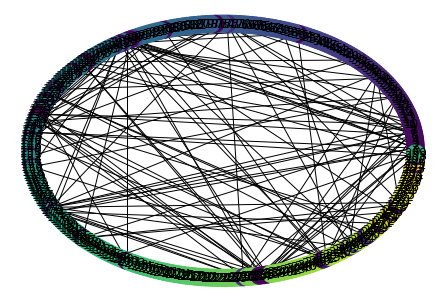

[0] [1, 7, 10, 236, 298] [2] [3] [4] [5] [6, 90, 99, 136, 146, 186, 251, 276, 279, 295] [8] [9] [11] [12, 38, 113, 152] [13] [14] [15] [16] [17] [18] [19] [20] [21, 56, 77, 102, 114, 137, 139, 143, 156, 235, 252] [22] [23] [24] [25] [26] [27] [28] [29, 104, 126] [30] [31, 74, 128, 172, 259, 265, 266, 280] [32] [33] [34] [35] [36] [37] [39] [40] [41] [42] [43] [44] [45] [46] [47] [48] [49] [50] [51] [52] [53] [54] [55] [57] [58] [59] [60, 98, 261] [61] [62] [63] [64] [65] [66] [67] [68] [69] [70] [71] [72] [73] [75] [76] [78] [79] [80] [81] [82] [83] [84] [85] [86] [87] [88] [89] [91, 95] [92] [93] [94] [96] [97] [100, 134, 138, 174, 200, 230, 234, 271] [101] [103] [105] [106] [107] [108] [109] [110] [111] [112] [115] [116] [117] [118, 131] [119] [120] [121] [122] [123] [124] [125] [127] [129] [130] [132] [133] [135] [140] [141] [142] [144] [145] [147] [148] [149] [150] [151] [153] [154] [155] [157] [158] [159] [160] [161] [162] [163] [164] [165] [166] [167] [168] [169] [170] [171] [173

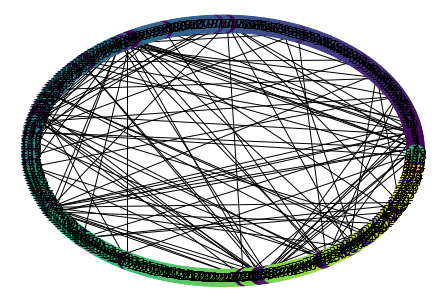

[0] [1, 7, 10, 31, 74, 172, 174, 230, 236, 271, 280, 298] [2] [3] [4] [5] [6, 90, 99, 136, 146, 186, 251, 276, 279, 295] [8] [9] [11] [12] [13] [14] [15] [16] [17] [18] [19] [20] [21, 56, 77, 102, 114, 137, 139, 143, 156, 235, 252] [22] [23] [24] [25] [26] [27] [28] [29, 104, 126] [30] [32] [33] [34] [35] [36] [37] [38, 113, 152] [39] [40] [41] [42] [43] [44] [45] [46] [47] [48] [49] [50] [51] [52] [53] [54] [55] [57] [58] [59] [60, 98, 261] [61] [62] [63] [64] [65] [66] [67] [68] [69] [70] [71] [72] [73] [75] [76] [78] [79] [80] [81] [82] [83] [84] [85] [86] [87] [88] [89] [91] [92] [93] [94] [95] [96] [97] [100, 118, 131, 134, 138, 200, 234] [101] [103] [105] [106] [107] [108] [109] [110] [111] [112] [115] [116] [117] [119] [120] [121] [122] [123] [124] [125] [127] [128, 259, 265, 266] [129] [130] [132] [133] [135] [140] [141] [142] [144] [145] [147] [148] [149] [150] [151] [153] [154] [155] [157] [158] [159] [160] [161] [162] [163] [164] [165] [166] [167] [168] [169] [170] [171] [17

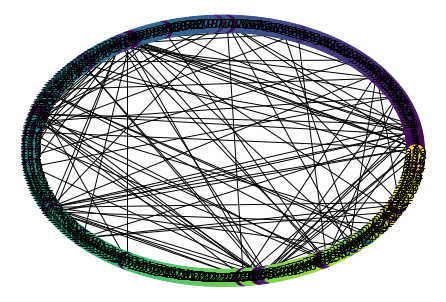

In [112]:
G = add_feature_vector(G, [('uniform', (0, 1)), ('uniform', (0, 1)), ('uniform', (0, 1)), ('uniform', (0, 1)), ('uniform', (0, 1))])
G = add_vulnerability_of_node(G, 'uniform', 0, 1)
G = add_age_to_edges(G)
for i in range(10):
    G = simulate_one_time_step(G, 0.95, 0)
    print(*get_clusters(G))
    partition = community_louvain.best_partition(G)
    nx.draw(G, pos, node_color=list(partition.values()), with_labels = 1);
    plt.show()

In [113]:
G.number_of_edges()

200

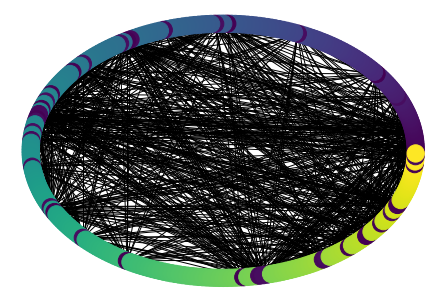

In [114]:
G = Simulate(G, 1000, 0.8)
partition = community_louvain.best_partition(G)
nx.draw(G, pos, node_color=list(partition.values()), with_labels = 0);
plt.show()

In [115]:
G.number_of_edges()

745